In [1]:
import numpy as np
import scipy
import scipy.stats as stats
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import seaborn as sns

In [2]:
sns.set_theme()

# Practical lecture 2: Sampling with Metropolis (Solution notebook)

Let us consider a coin that lands heads with probability $\theta=0.25$ (assumed unknown). 
Our prior knowledge is $\theta \sim \mathrm{Beta}(a=20, b=10)$

We toss the coin $n$ times and measure a number $y$ of heads. How does our belief of $\theta$ change with the measurement?

## Problem formalization

Formally, we have the model:

\begin{align*}
\theta \sim \rm{Beta}(a,b)\\
y \mid \theta \sim \rm{Bin}(n, \theta).
\end{align*}

The question is: what is the posterior distribution of $\theta$ given the observation $y$? In other words, what is $\theta \mid y$?<br/>In this lab session, we solve this problem in different ways:
* Exact defivation
* Brute-force
* Metropolis implemented from scratch
* Probabilistic programming (pyMC)

In [3]:
a = 20 # prior: parameter a
b = 10 # prior: parameter b
n = 50 # likelihood: number of tosses
y = 15 # likelihood: number of HEADs observed. (Fixed in this example. It could be sampled from a binomial instead)
#np.random.seed(42)
#y = np.random.binomial(n, theta) # random number of heads from the distribution from a binomial distribution

## Approach 1: Exact derivation

* Obtain the posterior distribution $f_{\rm post}(\theta) = f(\theta | y)$ in closed-form:

1. The pdf of the prior $\rm{Beta}(a,b)$ is:
$$ f_{\rm prior}(\theta) = \frac{1}{B(a,b)} \theta^{a-1} (1-\theta)^{b-1}, \qquad \theta \in (0, 1),$$


2. The likelihood function $\mathcal{L}(\theta) = P(y \mid \theta)$ is:

$$ \mathcal{L}(\theta) = {{n}\choose{y}} \theta^{y} (1-\theta)^{n-y}. $$

3. By applying Bayes rule, we obtain in close form the posterior probability density function:
$$f_{\mathrm{post}}(\theta) = f(\theta \mid y) = \frac{f_{\mathrm{prior}}(\theta) \mathcal{L}(\theta)}
{\int_\theta f_{\mathrm{prior}}(\theta) \mathcal{L}(\theta)\; d\theta} \propto \theta^{a+y-1} (1-\theta)^{b+n-y-1}, \qquad \theta \in (0, 1).$$
Which reveals that:
$$\theta \mid y \sim \mathrm{Beta}(\overbrace{a+y}^{=a'}, \overbrace{b + n - y}^{=b'}),$$
i.e. the posterior has the same $\mathrm{Beta}$ structure as the prior, with updated coefficients $a', b'$.

* Define random variables corresponding to the prior and the posterior in Python using `scipy.stats.beta`

In [4]:
a_post = a + y
b_post = b + n - y
prior_var = stats.beta(a=a, b=b)
post_var = stats.beta(a=a_post, b=b_post) # conjugate prior-likelihood case, closed-form expression known

* Plot the prior and posterior distribution of $\theta$, together with 95% HDI

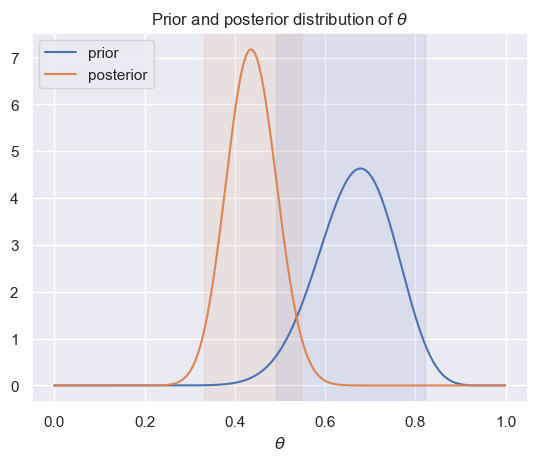

In [5]:
dtheta = 1e-3 # discretization step for theta
theta_vec = np.arange(0, 1, dtheta) # discretized theta range
alpha = 0.05
plt.plot(theta_vec, prior_var.pdf(theta_vec), label="prior", color="C0")
prior_L, prior_H = prior_var.interval(1-alpha)
plt.axvspan(xmin=prior_L, xmax=prior_H, alpha=0.1, color="C0")
plt.plot(theta_vec, post_var.pdf(theta_vec), label="posterior", color="C1")
post_L, post_H = post_var.interval(1-alpha)
plt.axvspan(xmin=post_L, xmax=post_H, alpha=0.1, color="C1")
#plt.axvline(theta_0, color="black", label=r"true $\theta$")
plt.xlabel(r"$\theta$")
plt.legend()
plt.title(r"Prior and posterior distribution of $\theta$");

* What are the limitations of the exact derivation approach?

It is only applicable to very special cases (conjugate prior/likelihood pairs).

## Approach 2: Gridding

* Compute the posterior as the product of the prior and the likelihood (up to a multiplicative factor independent of $\theta$) on a grid:

\begin{align}
\text{prior}: f_{\rm prior}(\theta) &\propto  \theta^{a-1} (1-\theta)^{b-1}\\
\text{likelihood}: \mathcal{L}(\theta) &= P(y \mid \theta) \propto  \theta^{y} \cdot (1-\theta)^{n-y},\\
\text{posterior}: f_{\rm post}(\theta) &\propto f_{\rm prior}(\theta) \mathcal{L}(\theta)
\end{align}


In [6]:
# Define prior, likelihood, and unnormalized posterior functions
prior_fun = lambda theta: stats.beta.pdf(theta, a, b)
lik_fun = lambda theta: (theta ** y) * (1 - theta)**(n-y)

def unnorm_prior_fun(theta):
    p_theta = theta**(a-1)*(1-theta)**(b-1) # since we look for an unnormalized posterior, this is also good enough
    p_theta = p_theta * ((theta <= 1.0) & (theta >= 0.0))
    return p_theta

unnorm_post_fun = lambda theta: unnorm_prior_fun(theta)*lik_fun(theta)

# Compute the unnormalized posterior on the grid
dtheta = 1e-3
theta_vec = np.arange(0, 1, dtheta)
unnorm_post = unnorm_post_fun(theta_vec)

* Obtain the normalized posterior by normalizing the unnormalized posterior. A distribution has to integrate to 1!

In [7]:
dtheta = 1e-3
theta_vec = np.arange(0, 1, dtheta)
Z = np.sum(unnorm_post_fun(theta_vec)) * dtheta
norm_post = unnorm_post / Z

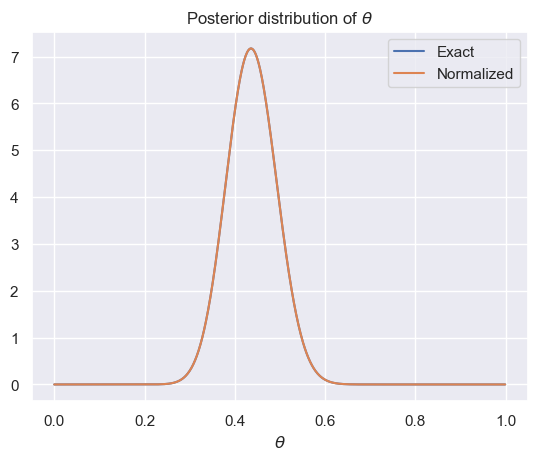

In [8]:
# Verify that the gridding approximation of the posterior is close to the exact solution
plt.plot(theta_vec, post_var.pdf(theta_vec), label="Exact")
plt.plot(theta_vec, norm_post, label="Normalized")
plt.xlabel(r"$\theta$");
plt.legend()
plt.title(r"Posterior distribution of $\theta$");

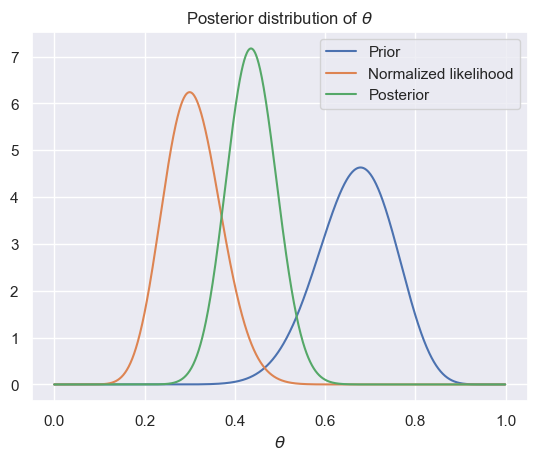

In [9]:
# Plot prior, (normalized) likelihood, and posterior
plt.plot(theta_vec, prior_fun(theta_vec), label="Prior")
lik_vec = lik_fun(theta_vec); lik_vec = lik_vec / np.sum(lik_vec) / dtheta  # normalize likelihood for plotting
plt.plot(theta_vec, lik_vec, label="Normalized likelihood")
plt.plot(theta_vec, norm_post, label="Posterior")
plt.xlabel(r"$\theta$");
plt.legend()
plt.title(r"Posterior distribution of $\theta$");

NOTE: It's actually better to implement the gridding approach in the log-domain (as done in the previous lab session)


* What are the limitations of the gridding approach?

It is only applicable in 1,2,3 dimensions as it suffers the curse of dimensionality. 

## Approach 3: Metropolis

Let us now assume that we can only evaluate only evaluate $f_{\rm post}(\theta)$ up to an unknown multiplicative factor $K$, which is in general the case for non-conjugate prior/likelihood pairs. All we know is that: 

$$ f_{\rm post}(\theta) = Kf_{\mathrm{prior}}(\theta) \mathcal{L}(\theta). $$

This is still sufficient to implement the Metropolis algorithm, since the accept/reject decision of this algorithm, is based on the *ratio* of $f_{\rm post}$ at two points $\theta_{\rm proposal}, \theta_{\rm current}$. The normalization constant is not really needed, since it cancels out in the computation of such ratio!

* Implement a Metropolis algorithm to obtain a sample-based approximation of the posterior $f_{\rm post}(\theta)$. 
    * Use as target distribution the unnormalized posterior `unnorm_post_fun`
    * Use the following proposal:
    $$\theta_{\rm proposal} = \theta_{\rm current} + \Delta \theta, \qquad \Delta \theta \sim \mathcal{N}(0, \sigma^2).$$
    * Set $\sigma = 0.1$ and initialize $\theta_{\rm current} = 0.5$
    * Run a single chain of length 50000.
    
Hint: the Metropolis algorithm for the Beta-Binomial model is described at pages 22-23 of lecture notes "Markov Chain Monte Carlo"

In [10]:
sigma = 0.1 # proposal standard deviation
theta_0 = 0.5 # an initial guess
N = 50_000 # chain length

In [11]:
theta_curr = theta_0
p_curr = unnorm_post_fun(theta_curr)
thetas = [] # here we collect the theta values from the chain

for idx in range(N):
    thetas.append(theta_curr)
    
    theta_prop = theta_curr + sigma*np.random.randn()
    theta_prop = np.clip(theta_prop, 0.0001, 0.9999)
    p_prop = unnorm_post_fun(theta_prop) # evaluate unscaled distribution
  
    p_ratio = p_prop/p_curr # the multiplicative factor disappears from the ratio!
    if p_ratio > 1:
        accept = True
    else:
        accept =  np.random.binomial(1, p_ratio) # othewise, accept w.p. p_ratio
        #accept = scipy.stats.bernoulli(p_ratio).rvs() # way slower!
    
    if accept:
        theta_curr = theta_prop
        p_curr = p_prop

In [12]:
thetas = thetas[1000:]

* Compare the Metropolis samples with the theoretical distribution. What do you observe?

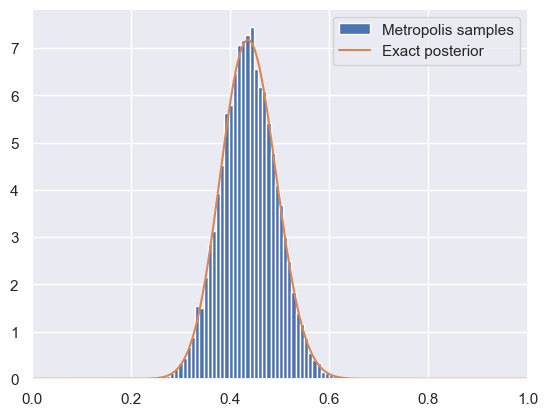

In [13]:
plt.hist(thetas, density=True, bins=50, label="Metropolis samples")
plt.plot(theta_vec, post_var.pdf(theta_vec), label="Exact posterior")
plt.legend()
plt.xlim([0, 1]);

The MCMC samples seem to approximate the true posterior very well!

## Logarithm implementation 
The unnormalized posterior distribution has a bad numerical scaling (in this case, and in general!). In some cases, this can become an issue.

The standard approach is to work out all operations in log-domain:

\begin{align*}
\ell(\theta) &= \log \mathcal{L}(\theta) = {n \choose y} + y \log (\theta) + (n-y) \log (1-\theta) \\
 \log f_{\rm prior}(\theta) &= -\log({B(a,b)}) + (a-1) \log (\theta) + (b-1)\log(1-\theta) \\
 g(\theta) = \log f_{\rm post}(\theta) &= \ell(\theta) + \log f_{\rm prior}(\theta) + \log f(y).
\end{align*}

As it is often the case, it is possible to discard *additive* constants from the log-posterior.

In [14]:
def log_lik_fun(theta):

    eps = 1e-12
    theta = np.minimum(theta, 1 - eps)
    theta = np.maximum(theta, eps)
    
    log_lik =  y * np.log(theta) + (n-y)*np.log(1 - theta)
    return log_lik

def unnorm_log_prior_fun(theta): # otherwise, use prior_dist.logpdf
    
    eps = 1e-12
    theta = np.minimum(theta, 1 - eps)
    theta = np.maximum(theta, eps)

    log_f_theta = (a-1)*np.log(theta) + (b-1)*np.log(1-theta) 
    #log_f_theta = log_f_theta * ((theta <= 1.0) & (theta >= 0.0)) # 
    return log_f_theta

unnorm_log_post_fun = lambda theta: log_lik_fun(theta) + unnorm_log_prior_fun(theta)

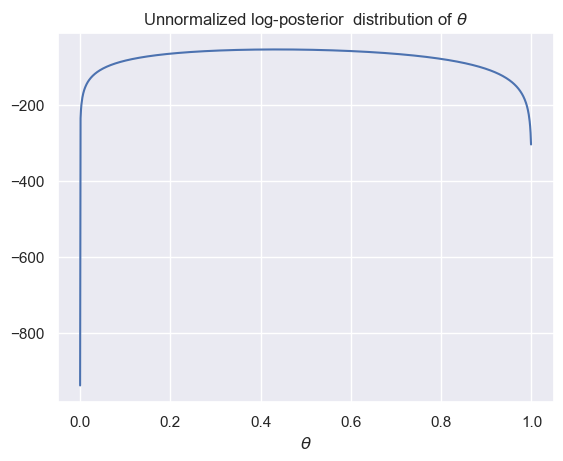

In [15]:
dtheta = 1e-3
theta_vec = np.arange(0, 1, dtheta)
plt.plot(theta_vec, unnorm_log_post_fun(theta_vec))
plt.xlabel(r"$\theta$");
plt.title(r"Unnormalized log-posterior  distribution of $\theta$");

The log-posterior has a much better scaling!

Actually, all we need to implement Metropolis is the ratio:
$$f_{\rm ratio}(\theta_{\rm proposal}, \theta_{\rm current}) = \frac{f_{\rm post}(\theta_{\rm proposal})}{f_{\rm post}(\theta_{\rm current})}$$
Then, $f_{\rm ratio}(\theta_{\rm proposal}, \theta_{\rm current})$  may be computed in a numerically stable way by exponentiating the difference between the log-posteriors at $\theta_{\rm proposal}$ and $\theta_{\rm current}$,  exploiting the identity:


$$f_{\rm ratio}(\theta_{\rm proposal}, \theta_{\rm current}) = \frac{f_{\rm post}(\theta_{\rm proposal})}{f_{\rm post}(\theta_{\rm current})} = e^{(\log f_{\rm post}(\theta_{\rm proposal})- \log f_{\rm post}(\theta_{\rm current}))} = e^{(g(\theta_{\rm proposal})- g(\theta_{\rm current}))}.$$

The additive constant disappears from the difference between the log-likelihood in 2 points, and the quantity to be exponentiated is not too large!

In general, the *golden rule* is to perform as many operations as possible in the logarithm and go back only when it is strictly necessary.

* Implement a Python function `f_ratio_fun` to compute $f_{\rm ratio}(\theta_{\rm proposal}, \theta_{\rm current})$, exploiting the above trick

In [16]:
def f_ratio_fun(theta_propose, theta_current):
       
    log_f_propose = unnorm_log_post_fun(theta_propose)
    log_f_current = unnorm_log_post_fun(theta_current)
    log_f_ratio = log_f_propose - log_f_current # log(f_prop/f_prev) = log(f_prop) - log(f_prev)
    f_ratio = np.exp(log_f_ratio)
    #f_ratio = np.nan_to_num(p_ratio, nan=0.0)
    return f_ratio

* Implement a Metropolis algorithm using the newly defined `f_ratio_fun`. Comment the results.

In [17]:
theta_curr = theta_0
thetas = [] # here we collect the theta values from the chain

for idx in range(N):
    thetas.append(theta_curr)
    
    # Generate proposal
    theta_prop = theta_curr + sigma*np.random.randn()
    theta_prop = np.clip(theta_prop, 0.0001, 0.9999)
    
    f_ratio = f_ratio_fun(theta_prop, theta_curr) 
    accept_prob = np.minimum(1.0, f_ratio)
    
    accept = (np.random.rand() < accept_prob)
    
    if accept:
        theta_curr = theta_prop

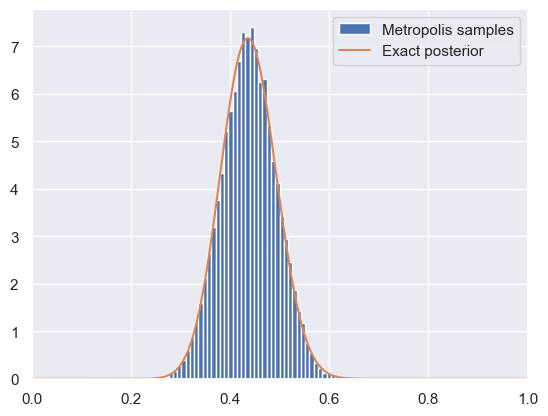

In [18]:
plt.hist(thetas, density=True, bins=50, label="Metropolis samples")
plt.plot(theta_vec, post_var.pdf(theta_vec), label="Exact posterior")
plt.legend()
plt.xlim([0, 1]);

We obtain the same result as before.

* Try our different values of sigma and comment the results

In [19]:
sigma = 0.1 # proposal standard deviation
theta_0 = 0.5 # a lucky guess...
N = 50_000 # chain length

theta_curr = theta_0
thetas_test = [] # here we collect the theta values from the chain

for idx in range(N):
    thetas.append(theta_curr)
    theta_prop = theta_curr + sigma*np.random.randn()
    theta_prop = np.clip(theta_prop, 0.0001, 0.9999)
    
    f_ratio = f_ratio_fun(theta_prop, theta_curr)
    accept_prob = np.minimum(1.0, p_ratio)
    accept = (np.random.rand() < accept_prob)
    
    if accept:
        theta_curr = theta_prop

In [20]:
#plt.hist(thetas, bins=50);

## Approach 4: Probabilistic Programming

* Implement a sample-based estimation of the posterior of $\theta$ with pymc

The Beta-Binomial is the Hello World of probabilistic programming! No need to worry about implementation subtleties of sampling, pymc
takes care of it!

In [21]:
# Approach 4: use pymc

with pm.Model() as beta_binomial:
    theta = pm.Beta("theta", alpha=a, beta=b)
    y_obs = pm.Binomial("y_obs", n=n, p=theta, observed=y)
    trace_bb = pm.sample(10_000, random_seed=123, return_inferencedata=True)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Output()

Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 2 seconds.


In [22]:
with beta_binomial:
    display(az.summary(trace_bb))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.437,0.055,0.334,0.54,0.0,0.0,16449.0,27349.0,1.0


In [23]:
np.mean(thetas), np.std(thetas) # comparison with hand-made metropolis

(np.float64(0.46952669554144666), np.float64(0.22827407543409517))

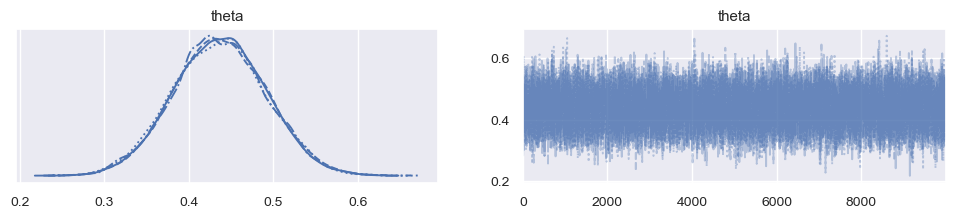

In [24]:
az.plot_trace(trace_bb);

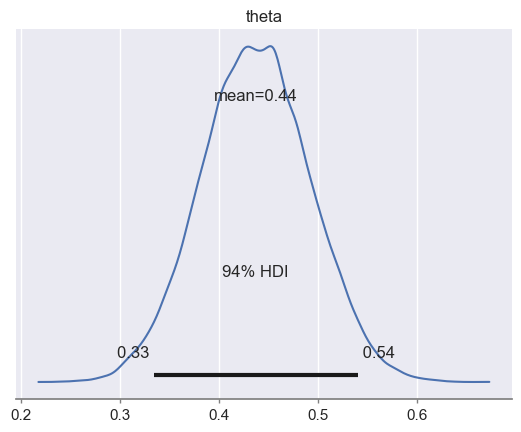

In [25]:
az.plot_posterior(trace_bb, color="b");

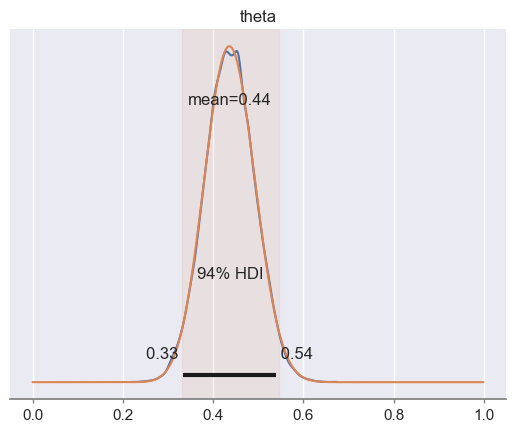

In [26]:
az.plot_posterior(trace_bb, color="C0")
plt.plot(theta_vec, post_var.pdf(theta_vec), color="C1")
post_L, post_H = post_var.interval(1-alpha)
plt.axvspan(xmin=post_L, xmax=post_H, alpha=0.1, color="C1", label=r"HDI 95%");